# Shape Interpolation

In [6]:
from mmot import MMOTSolver

import numpy as np 
import matplotlib.pyplot as plt 
import itertools

In [7]:
measures = [None]*4
measures[0] = 1 - plt.imread('images/redcross.png')[:, :, 2]
measures[1] = 1 - plt.imread('images/tooth.png')[:, :, 2]
measures[2] = 1 - plt.imread('images/heart.png')[:, :, 2]
measures[3] = 1 - plt.imread('images/duck.png')[:, :, 2]

pad = 4
for i in range(len(measures)):
    temp= measures[i]*np.prod(measures[i].shape)/np.sum(measures[i])
    measures[i] = np.zeros((measures[i].shape[0]+2*pad,measures[i].shape[1]+2*pad))
    measures[i][pad:-pad,pad:-pad] = temp

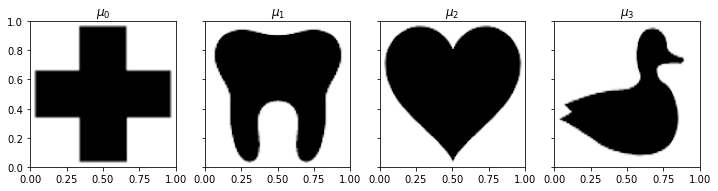

In [8]:
# Grid of size n1 x n2
n1,n2 = measures[0].shape

x, y = np.meshgrid(np.linspace(0.5/n1,1-0.5/n1,n1), np.linspace(0.5/n2,1-0.5/n1,n2))


# Normalize all the measures
for i in range(len(measures)):
    measures[i] *= n1*n2 / np.sum(measures[i])

fig, ax = plt.subplots(1, len(measures), figsize=(12,4),sharey=True)
for i in range(len(measures)):
    ax[i].imshow(measures[i], extent=(0,1,0,1), cmap='Greys')
    ax[i].set_title("$\\mu_{{ {:0d} }}$".format(i))

In [9]:
def Solve(bary_weights):
    unroll_node = 1
    bary_weights /= np.sum(bary_weights)

    # Only keep the measures with positive weights
    keep_inds = np.where(bary_weights>0)[0]
    bary_weights = bary_weights[keep_inds]
    if(len(keep_inds)==1):
        return measures[keep_inds[0]]
    
    keep_measures = [measures[i] for i in keep_inds]

    # Construct the edge list for the barycenter problem
    edge_list = []
    for i in range(len(keep_inds)):
        for j in range(i+1,len(keep_inds)):
            edge_list.append([i,j])

    # Set up the MMOT solver
    prob = MMOTSolver(keep_measures, edge_list, x, y, unroll_node, bary_weights)
    dual_vars = [np.zeros(x.shape) for i in range(prob.NumDual())]

    num_its = 1000
    step_size = 0.2
    costs = np.nan*np.zeros(num_its)

    ftol = 0.0
    gtol = 1e-6

    root_nodes = np.arange(prob.NumDual())
    root_cycler = itertools.cycle(root_nodes)
    old_cost = prob.ComputeCost(dual_vars)

    alpha = 1.0/1.5
    print('Iteration, StepSize,    Cost,     Error,  Line Its')
    for i in range(num_its):


        alpha = np.minimum(1.5*alpha,1.0) 
        #alpha = 1.0
        line_it = 0
        max_line_its = 20
        while(line_it<max_line_its):
            new_duals = np.copy(dual_vars)
            newSqNorm = prob.Step(next(root_cycler), new_duals, alpha*step_size)
            if(line_it==0):
                gradSqNorm = newSqNorm
            new_cost = prob.ComputeCost(new_duals)

            if(new_cost>=old_cost+1e-4*step_size*alpha*gradSqNorm):
                costs[i] = new_cost 
                old_cost = np.copy(new_cost)
                dual_vars = np.copy(new_duals)
                break
            else:
                alpha *=0.5
                
            line_it += 1

        if(line_it>=max_line_its):
            print('{:9d},   {:0.4f},  {:0.4e},   {:0.4e},  {:8d}'.format(i,step_size, costs[i-1], gradSqNorm, line_it))
            print('Terminating due to failed line search.')
            break 
        #if(i>0):
        #    step_size = prob.StepSizeUpdate(step_size, costs[i], costs[i-1], error)

        if((i%10)==0):
            print('{:9d},   {:0.4f},  {:0.4e},   {:0.4e},  {:8d}'.format(i,step_size, costs[i], gradSqNorm, line_it))

        # Check for convergence in cost
        if(np.abs(costs[i]-costs[i-1])<ftol):
            print('{:9d},   {:0.4f},  {:0.4e},   {:0.4e},  {:8d}'.format(i,step_size, costs[i], gradSqNorm, line_it))
            print('Terminating due to small change in objective.')
            break

        # Check for convergence via gradient 
        if(gradSqNorm<gtol):
            print('{:9d},   {:0.4f},  {:0.4e},   {:0.4e},  {:8d}'.format(i,step_size, costs[i], gradSqNorm, line_it))
            print('Terminating due to small gradient norm.')
            break 
    
    return prob.Barycenter(dual_vars)

In [10]:
fig=plt.figure(figsize=(8,8)) 

vmax = np.max(measures[0])

size=0.26
corner_pos = np.array([[0.0,1.0], [0.0,0.0], [1.0,1.0], [1.0,0.0]])

for i,m in enumerate(measures):
    ax=fig.add_axes([corner_pos[i,0],corner_pos[i,1],size,size])
    ax.imshow(measures[i],extent=(0,1,0,1),cmap='Greys',vmin=0, vmax=vmax)
    ax.set_axis_off()


for w1 in np.linspace(0,1,5):
    for w2 in np.linspace(0,1,5):
        weights = [(1.0-w1)*w2, (1.0-w1)*(1.0-w2), w1*w2, w1*(1.0-w2)]
        if(np.max(weights)<1.0-1e-12):
            avg_pos = [w1,w2]
            
            bary = Solve(weights)

            ax=fig.add_axes([avg_pos[0],avg_pos[1],size,size])
            ax.imshow(bary,extent=(0,1,0,1),cmap='Greys',vmin=0, vmax=vmax)
            ax.set_axis_off()
            
plt.savefig('ShapeInterpolation.pdf',bbox_inches='tight')

1
Iteration, StepSize,    Cost,     Error,  Line Its
        0,   0.2000,  6.0340e-04,   1.7632e-02,         0
       10,   0.2000,  1.3057e-03,   3.9328e-05,         2
       20,   0.2000,  1.3070e-03,   5.1735e-06,         2
       30,   0.2000,  1.3071e-03,   4.9021e-06,         2
       40,   0.2000,  1.3071e-03,   4.7391e-06,         2
       50,   0.2000,  1.3072e-03,   4.6030e-06,        12
       57,   0.2000,  1.3072e-03,   7.0318e-06,        20
Terminating due to failed line search.
1
Iteration, StepSize,    Cost,     Error,  Line Its
        0,   0.2000,  1.3479e-03,   1.7632e-02,         0
       10,   0.2000,  1.7414e-03,   1.9939e-05,         1
       20,   0.2000,  1.7427e-03,   5.1812e-06,         2
       30,   0.2000,  1.7428e-03,   4.9146e-06,         2
       40,   0.2000,  1.7428e-03,   4.7585e-06,         2
       50,   0.2000,  1.7430e-03,   4.6495e-06,         4
       60,   0.2000,  1.7430e-03,   4.5739e-06,        12
       69,   0.2000,  1.7430e-03,   7.0576e